# Automated Data Cleaning (autoClean)

Welcome to **autoClean**, this program takes in as input a **dataset** and will eventually return a ***cleaned* dataset** to the user. Throughout the data cleaning process, the program will regularly prompt the user with certain queries about the data to leverage human judgement. Such queries may ask whether dropping duplicates of a certain column is acceptable, etc. Therefore this program necessitates interaction with the user, but will hopefully provide a clean dataset that matches the user's intentions by the end. All interaction will occur through Jupyter Notebook's input prompt.

### How to use autoClean
It is very simple, just read through each of the text snippets and run each of the code sections using (shift + enter).  Be patient, certain cells can take up to a few minutes to run.
**IMPORTANT NOTE: this program does not work on Safari. Ideally run this on Firefox.**

## Step 0: Install Dependencies and Import Libraries
Run the below cell if needed, or you can download the libraries directly through your terminal. Note that you may need to modify the installer to pip depending on your set up. But make sure to run the following cell which include all libraries necessary for this program.

In [ ]:
!pip3 install -U -q ipywidgets
!pip3 install chart-studio
!pip3 install cufflinks
!pip3 install jupyterlab
!pip3 install ipywidgets
!pip3 install jupyterlab_widgets
!pip3 install widgetsnbextension
!pip3 install missingno
!jupyter nbextension enable --py --sys-prefix widgetsnbextension
!jupyter labextension install @jupyter-widgets/jupyterlab-manager

In [1]:
import numpy as np
import pandas as pd
import scipy
import math
import matplotlib.pyplot as plt
import re
import time
import itertools
from ngram import NGram
from dateutil.parser import parse

from chart_studio import plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
init_notebook_mode(connected=True)

import cufflinks as cf
cf.go_offline(connected=True)
cf.set_config_file(colorscale='plotly', world_readable=True)

# Extra options
pd.options.display.max_rows = 30
pd.options.display.max_columns = 25

# Show all code cells outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

import os
from IPython.display import Image, display, HTML

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

from scipy.spatial.distance import pdist, squareform
from scipy import stats

import missingno as msno
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

## Step 1: Provide the Dataset
Please respond to the prompt below with the filepath of the dataset you wish to be cleaned. Note that the input dataset must be a **.csv** file, and quotation marks around the filepath is **not** necessary. The default delimiter for CSV files are commas (','), if your csv file uses an alternate delimiter, please specify this in the second prompt (after the initial prompr about filepath), otherwise the comma delimiter is assumed. Additionally remember that the filepath must be relative to this file in order for the program to work properly. 

In [2]:
filepath = input("filepath: ")
delimiter = input("delimiter: ")

filepath: loandata.csv
delimiter: 


In [3]:
if delimiter == '':
    df = pd.read_csv(filepath)
else:
    df = pd.read_csv(filepath, sep=delimiter)
df["id"] = df.index

## Step 2: Explore and Understand the Data
This step will survey the dataset and see what the various fields are as well as note down any peculiarities with any of the fields or data.

In [4]:
print('\033[1m' + "Characteristics of Input Dataset" + '\033[0m')
print("Number of fields/characteristics:", df.shape[1])
print("Number of data entries:", df.shape[0])
print("-----------------------------------------------")
print('\033[4m' + "Number of missing entries per column:" + '\033[0m')
print(df.isnull().sum())
print("-----------------------------------------------")
print('\033[4m' + "Datatype of each column:"+ '\033[0m')
print(df.dtypes)


Characteristics of Input Dataset
Number of fields/characteristics: 12
Number of data entries: 1311
-----------------------------------------------
Number of missing entries per column:
race          30
gender        19
date           1
zip           31
income       250
type           1
term           0
interest       0
principal      0
approved       0
adj_bls_2      0
id             0
dtype: int64
-----------------------------------------------
Datatype of each column:
race          object
gender        object
date          object
zip          float64
income       float64
type          object
term           int64
interest     float64
principal      int64
approved        bool
adj_bls_2    float64
id             int64
dtype: object


In [5]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

@interact
def describe(column=list(df.columns)):
    print(df[column].describe())

interactive(children=(Dropdown(description='column', options=('race', 'gender', 'date', 'zip', 'income', 'type…

In [6]:
print("-----------------------------------------------")
print('\033[4m' + "Most Common Data Entries By Column" + '\033[0m')
for column in df:
    unique_vals = df[column].unique()
    if len(unique_vals) < (df.shape[0]/10):
        print('\n'+'\033[1m' + '\033[4m' + "Column: " + column + '\033[0m')
        print(df[column].value_counts().head())

-----------------------------------------------
Most Common Data Entries By Column

Column: race
black              421
white              400
hispanic/latino    221
other              161
asian               66
Name: race, dtype: int64

Column: gender
female        664
male          623
non-binary      5
Name: gender, dtype: int64

Column: date
2016-01-01    24
2018-03-01    24
2016-11-01    24
2018-11-01    24
2017-07-01    23
Name: date, dtype: int64

Column: zip
60623.0    266
60625.0    238
60614.0    203
60637.0    166
60615.0    160
Name: zip, dtype: int64

Column: type
home        500
auto        481
personal    329
Name: type, dtype: int64

Column: term
72     247
360    204
84     153
60     142
300    101
Name: term, dtype: int64

Column: approved
False    745
True     566
Name: approved, dtype: int64

Column: adj_bls_2
0.09    139
0.14     76
0.12     65
0.11     64
0.16     64
Name: adj_bls_2, dtype: int64


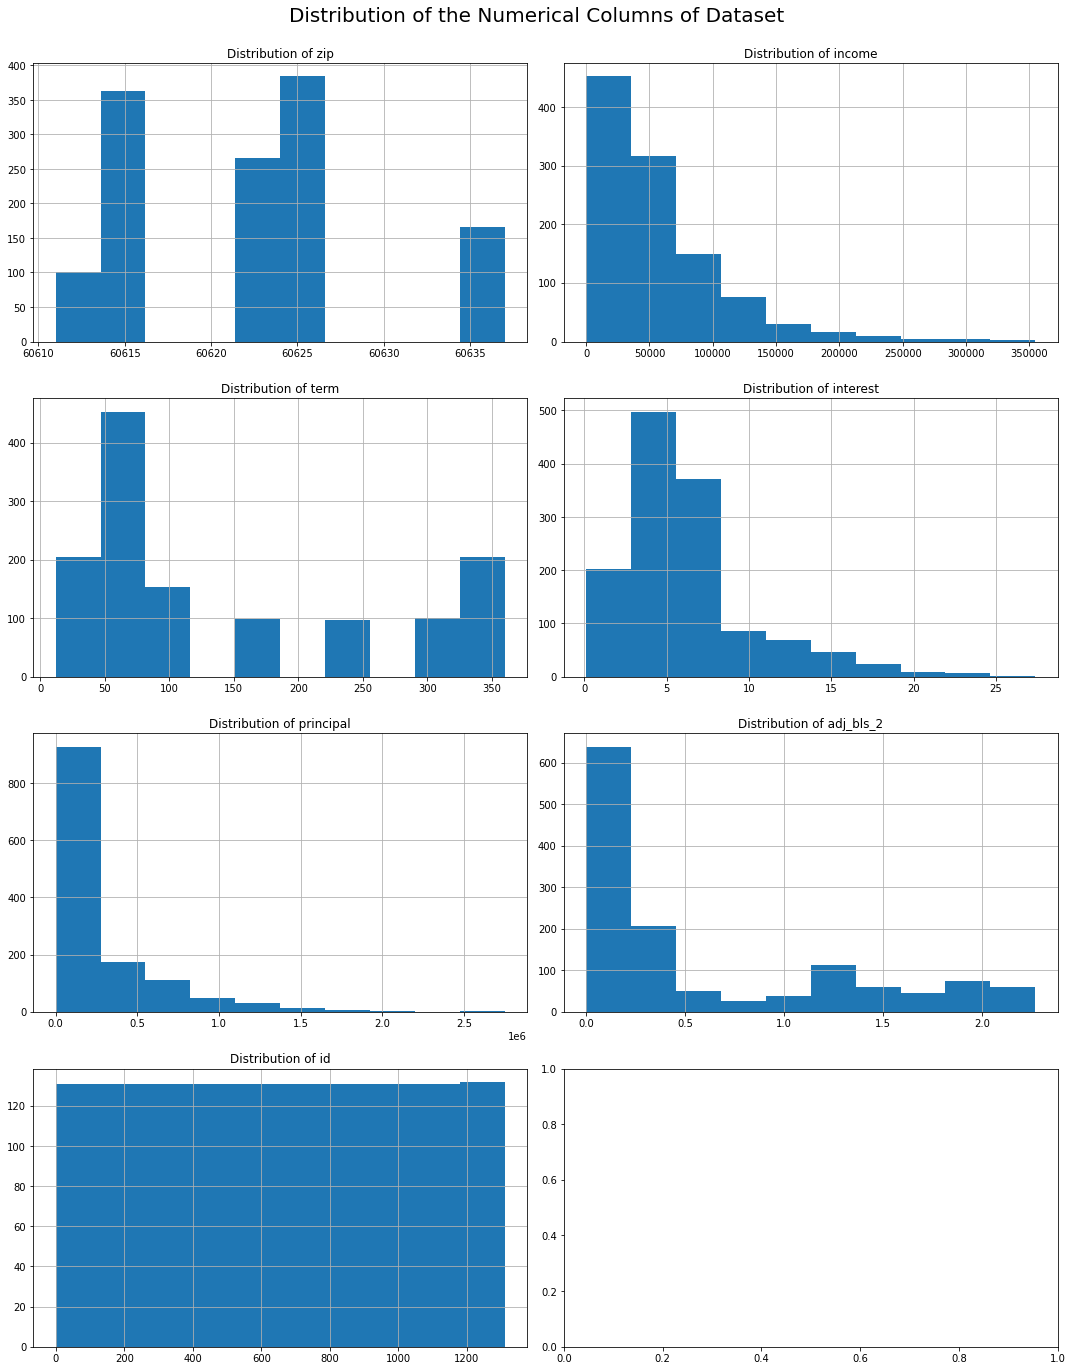

In [7]:
count = 0
numerical_columns = []
for column in df:
    if (df[column].dtypes == "int64" or df[column].dtypes == "float64"):
        numerical_columns.append(column)
        count += 1

fig, axes =  plt.subplots(math.ceil(count/2),2, figsize=(15,5 * math.ceil(count/2)))
i=0
j=0
for col in numerical_columns:
    #a[i][j].set_xlabel(col) , 
    df[col].hist(ax=axes[i][j])
    axes[i][j].set_title('Distribution of ' + col)
    if j == 1:
        j = 0
        i += 1
    else:
        j += 1
plt.suptitle("Distribution of the Numerical Columns of Dataset", fontsize=20)
fig.tight_layout(rect=[0, 0.03, 1, 0.98]);

## Step 3: Removing Non-Numerical Data Errors
This step invovles identifying any non-numerical data errors within the dataset, these can be in the form of duplicate removal and other patterns/rule violations. Each of these decisions will require user interaction to ensure that the data cleaning process matches the intentions of the user.

In [8]:
from IPython.display import display

def duplicate_clean (col):
    if (not df[col].is_unique):
        print("\n The '" + col + "' column contains duplicates, what would you like do? (pick one of the following options)")
        print("(1) Keep all duplicates")
        print("(2) Drop all duplicates that are identical across all columns")
        print("(3) Drop all duplicates of this column")
        time.sleep(0.05)
        dup_option = input('\033[1m' + "Input the option number: " + '\033[0m')
        if dup_option == "1" or dup_option == "(1)":
            return
        elif dup_option == "2" or dup_option == "(2)":
            df.drop_duplicates(inplace=True)
            return
        elif dup_option == "3" or dup_option == "(3)":
            print("Please specify 'first', 'last', or 'none' to indicate which duplicate, if any, should be kept.")
            time.sleep(0.05)
            drop_pref = input('\033[1m' + "Input drop preference: " + '\033[0m')
            if drop_pref == "none":
                df.drop_duplicates([col], keep=False, inplace=True)
                return
            else:
                df.drop_duplicates([col], keep=drop_pref, inplace=True)
                return

In [9]:
# standardize the groupings of a certain column, note that the data must be non-numerical
def clean_non_numerical (col):
    
    # for non-numerical columns with unqiue values more than half the number of rows check for duplicates
    unique_vals = df[col].unique()
    if (len(unique_vals) > 30):
        return duplicate_clean(col)
    
    # do not consider date columns
    def is_date(string):
        try: 
            parse(string)
            return True
        except ValueError:
            return False
    
    # check if date is valid
    for i, row_value in df[col].head(5).iteritems():
        if is_date(df[col][i]):
            return
    
    # check for abbreviated nation names
    if ('country' in col) or ('COUNTRY' in col) or ('Country' in col):
        invalid_df_us = df[(df[col] == 'United States') | (df[col] == 'United States of America') | (df[col] == 'USA') | (df[col] == 'usa') | (df[col] == 'us')]
        if invalid_df_us.shape[0] > 0:
            print("There are " + str(invalid_df_us.shape[0])+ " alternate references to the US. These age entries will be all be set to US.")
            df.loc[(df[col] == 'United States') | (df[col] == 'United States of America') | (df[col] == 'USA') | (df[col] == 'usa') | (df[col] == 'us'), [col]] = 'US'
        invalid_df_uk = df[(df[col] == 'United Kingdom') | (df[col] == 'uk')]
        if invalid_df_us.shape[0] > 0:
            print("There are " + str(invalid_df_us.shape[0])+ " alternate references to the UK. These age entries will be all be set to UK.")
            df.loc[(df[col] == 'United Kingdom') | (df[col] == 'uk'), [col]] = 'UK'
        
    # establish starting point
    unique_vals = ['None' if x is np.nan else x for x in unique_vals]
    unique_vals = ['None' if v is None else v for v in unique_vals]
    print("\n Initial set of unqiue entries in '" + col + "' column: "+ '\033[1m' + ", ".join(unique_vals) + '\033[0m')
    
    # remove leading and trailing blank spaces
    df[col] = df[col].replace(r"^ +| +$", r"", regex=True)
    
    # standardize all text to "title case"
    def title_case(string):
        if pd.isnull(string):
            return None
        return re.sub(r"[A-Za-z]+('[A-Za-z]+)?", lambda word: word.group(0).capitalize(), string)
    df[col] = df[col].apply(lambda x: title_case(x))
    
    # compare strings of all titles to see if they can be merged
    def ngram_compare(a,b):
        if NGram.compare(a,b) > 0.4:
            print("\n", a,b)
            time.sleep(0.05)
            combine = input("Would you consider the above two entries the same? (yes/no) ")
            if combine == 'yes' or combine == 'y':
                while True:
                    time.sleep(0.05)
                    combine_to = input("To which entry would you like the text to be merged to? (input field name)")
                    if combine_to == a:
                        df[col] = df[col].replace({b: a}, regex=True)
                        return
                    elif combine_to == b:
                        df[col] = df[col].replace({a: b}, regex=True)
                        return
                    else:
                        continue
    unique_vals = df[col].unique()
    for pair in itertools.combinations(unique_vals, r=2):
        ngram_compare(*pair)
    print("\n")
    # show end point
    unique_vals = df[col].unique()
    unique_vals = ['None' if v is None else v for v in unique_vals]
    print("Final set of unqiue entries in '" + col + "' column: "+ '\033[1m' + ", ".join(unique_vals) + '\033[0m' +"\n")

In [10]:
import warnings
warnings.filterwarnings('ignore')

for column in df:
    if(df[column].dtype == object):
        clean_non_numerical (column)
print("\n")
print('\033[1m' + "** Non-Numerical Data Cleaning Complete! **" + '\033[0m')


 Initial set of unqiue entries in 'race' column: hispanic/latino, other, black, white, asian, Hispanic/latino, Black,  black, black , white , White, blck, None, hispanic/lation, asiaan 

 Hispanic/Latino Hispanic/Lation
Would you consider the above two entries the same? (yes/no) yes
To which entry would you like the text to be merged to? (input field name)Hispanic/Latino

 Black Blck
Would you consider the above two entries the same? (yes/no) yes
To which entry would you like the text to be merged to? (input field name)Black

 Asian Asiaan
Would you consider the above two entries the same? (yes/no) yes
To which entry would you like the text to be merged to? (input field name)Asian


Final set of unqiue entries in 'race' column: Hispanic/Latino, Other, Black, White, Asian, None


 Initial set of unqiue entries in 'gender' column: male, female, non-binary, None


Final set of unqiue entries in 'gender' column: Male, Female, Non-Binary, None


 The 'date' column contains duplicates, what

## Step 4: Removing Numerical Data Errors
This step invovles identifying any non-numerical data errors within the dataset, these can be in the form of duplicate removal, outlier removal, and other patterns/rule violations. Each of these decisions will require user interaction to ensure that the data cleaning process matches the intentions of the user.  This step will process each column individually before finally considering the entire dataset to see if any hollistic changes need to be made.

In [13]:
def clean_numerical (col, df):
    
    # remove outliers
    print( "Input the number of standard deviations from the mean you are willing to include for the '" + '\033[1m' + col + '\033[0m' + "' column.")
    print("If you wish to keep outliers for this column, please write all.")
    time.sleep(0.05)
    sd = input("Input standard deviations: ")
    if sd != 'all':
        cols_outside_sd = df
        cols_outside_sd = cols_outside_sd[(np.abs(stats.zscore(df[col])) > int(sd))]
        print("There are " +'\033[1m'+ str(cols_outside_sd.shape[0]) + '\033[0m' + " rows that are outliers accoridng to your standard deviation value.")
        if cols_outside_sd.shape[0] > 0:
            print("These rows will be deleted from the original dataset.\n")
            df = df[(np.abs(stats.zscore(df[col])) < int(sd))]
        else:
            print("\n")
    
    # remove duplicates
    duplicate_clean(col)
    print("\n")
    
    
    
    # check if zip code is valid
    if ('zip' in col) or ('ZIP' in col):
        invalid_df = df[(df[col] < 1) | (df[col] > 99950)]
        if invalid_df.shape[0] > 0:
            print("There are " + str(invalid_df.shape[0])+ " invalid ZIP codes in your data. These ZIP entries will be set to null for now.\n")
            #df.drop(df[(df[col] < 1) | (df[col] > 99950)].index, inplace=True)
            df.loc[(df[col] < 1) | (df[col] > 99950), [col]] = np.nan

    
    # check if age is valid
    if ('age' in col) or ('AGE' in col):
        invalid_df = df[(df[col] < 0) | (df[col] > 120)]
        if invalid_df.shape[0] > 0:
            print("There are " + str(invalid_df.shape[0])+ " invalid ages in your data. These age entries will be set to null for now.\n")
            df.loc[(df[col] < 0) | (df[col] > 120), [col]] = np.nan

In [18]:
import warnings
warnings.filterwarnings('ignore')

for column in df:
    if(df[column].dtype == 'int64' or df[column].dtype == 'float64'):
        clean_numerical (column, df)

# Smart Duplication Removal
print("'Smart' duplication deletion: look at the numerical columns of duplicated rows and only delete duplicates that are 'similar'")
confirm = input("Confirm if you would like to run this duplicate deletion method: ")
if confirm == "yes" or confirm == "y":
    smart_dup = pd.DataFrame(1 - squareform(pdist(df.set_index('id'), lambda u,v: (u != v).mean())))
    smart_dup.values[[np.arange(smart_dup.shape[0])]*2] = 0
    smart_dup = smart_dup.mask(np.triu(np.ones(smart_dup.shape, dtype=np.bool_)))
    duplicates = smart_dup[smart_dup > 0.8]
    dup_list = np.stack(duplicates.notnull().values.nonzero()).T.tolist()
    print('\033[1m' + "Below is the set duplicated rows that our algorithm found: " + '\033[0m')
    print("Use the interactive toggle to compare the two 'similar' rows. Note that the duplicates will be deleted from the original dataframe.")
    for dup in dup_list:
        display(df.iloc[[dup[0],dup[1]],:])
    for dup in dup_list:
        try:
            df.drop(df.index[dup[0]], inplace=True)
        except:
            continue
print('\033[1m' + "** Numerical Data Cleaning Complete! **" + '\033[0m')

Input the number of standard deviations from the mean you are willing to include for the 'zip' column.
If you wish to keep outliers for this column, please write all.
Input standard deviations: 3
There are 0 rows that are outliers accoridng to your standard deviation value.



 The 'zip' column contains duplicates, what would you like do? (pick one of the following options)
(1) Keep all duplicates
(2) Drop all duplicates that are identical across all columns
(3) Drop all duplicates of this column
Input the option number: 1


Input the number of standard deviations from the mean you are willing to include for the 'income' column.
If you wish to keep outliers for this column, please write all.
Input standard deviations: 1
There are 0 rows that are outliers accoridng to your standard deviation value.



 The 'income' column contains duplicates, what would you like do? (pick one of the following options)
(1) Keep all duplicates
(2) Drop all duplicates that are identical across all columns


,race,gender,date,zip,income,type,term,interest,principal,approved,adj_bls_2,id
254,Hispanic/Latino,Male,NaN,60626.0,48705.0,Home,180,5.463631,360591,False,0.12,254
253,Hispanic/Latino,Male,2015-05-01,60626.0,48705.0,Home,180,5.463631,360591,False,0.12,253


,race,gender,date,zip,income,type,term,interest,principal,approved,adj_bls_2,id
271,Black,None,2012-08-01,60625.0,14199.0,None,48,8.784563,14844,True,0.13,271
270,Black,None,2012-08-01,60625.0,14199.0,Personal,48,8.784563,14844,True,0.13,270


,race,gender,date,zip,income,type,term,interest,principal,approved,adj_bls_2,id
1297,Black,Female,2018-06-01,60615.0,NaN,Personal,24,9.658455,71093,True,1.82,1297
315,Black,Female,2018-06-01,60615.0,NaN,Personal,24,9.658455,71093,True,1.82,315


,race,gender,date,zip,income,type,term,interest,principal,approved,adj_bls_2,id
1298,Black,Female,2018-06-01,60615.0,NaN,Personal,24,9.658455,71093,True,1.82,1298
315,Black,Female,2018-06-01,60615.0,NaN,Personal,24,9.658455,71093,True,1.82,315


,race,gender,date,zip,income,type,term,interest,principal,approved,adj_bls_2,id
1298,Black,Female,2018-06-01,60615.0,NaN,Personal,24,9.658455,71093,True,1.82,1298
1297,Black,Female,2018-06-01,60615.0,NaN,Personal,24,9.658455,71093,True,1.82,1297


,race,gender,date,zip,income,type,term,interest,principal,approved,adj_bls_2,id
1299,None,Female,2018-06-01,60615.0,NaN,Personal,24,9.658455,71093,True,1.82,1299
315,Black,Female,2018-06-01,60615.0,NaN,Personal,24,9.658455,71093,True,1.82,315


,race,gender,date,zip,income,type,term,interest,principal,approved,adj_bls_2,id
1299,None,Female,2018-06-01,60615.0,NaN,Personal,24,9.658455,71093,True,1.82,1299
1297,Black,Female,2018-06-01,60615.0,NaN,Personal,24,9.658455,71093,True,1.82,1297


,race,gender,date,zip,income,type,term,interest,principal,approved,adj_bls_2,id
1299,None,Female,2018-06-01,60615.0,NaN,Personal,24,9.658455,71093,True,1.82,1299
1298,Black,Female,2018-06-01,60615.0,NaN,Personal,24,9.658455,71093,True,1.82,1298


,race,gender,date,zip,income,type,term,interest,principal,approved,adj_bls_2,id
1302,None,Female,2011-07-01,60625.0,25230.0,Home,360,0.97487,182214,False,0.07,1302
1063,White,Female,2011-07-01,NaN,25230.0,Home,360,0.97487,182214,False,0.07,1063


** Numerical Data Cleaning Complete! **


## Step 5: Understanding and Addressing Missing Data
This step begins with presenting a series of charts that try to understand the missing data entries. This step is necessary to indicate whether the data is MCAR or MAR. Then we iterate over each column to see if there are any missing values. In the case that there is missing values, you will be posed with 4 different options to deal with them. Note that the way we deal with missing values depends on whether the column is numerical or not.

Visualizing the Missing Data: Completeness of Dataset


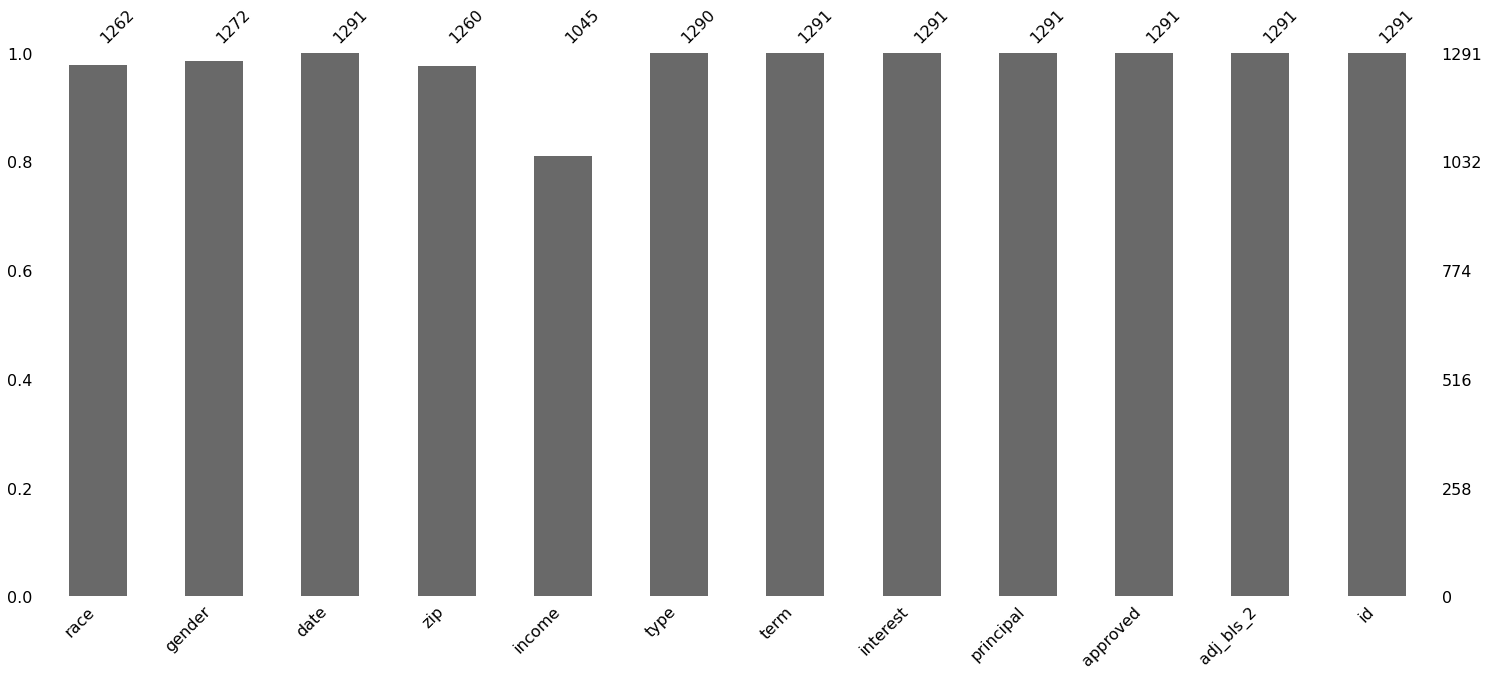

In [19]:
print('\033[1m' + "Visualizing the Missing Data: Completeness of Dataset" + '\033[0m')
msno.bar(df);

Visualizing the Missing Data: Data Completion Patterns
Note: This is from a random sample of 100 entries.


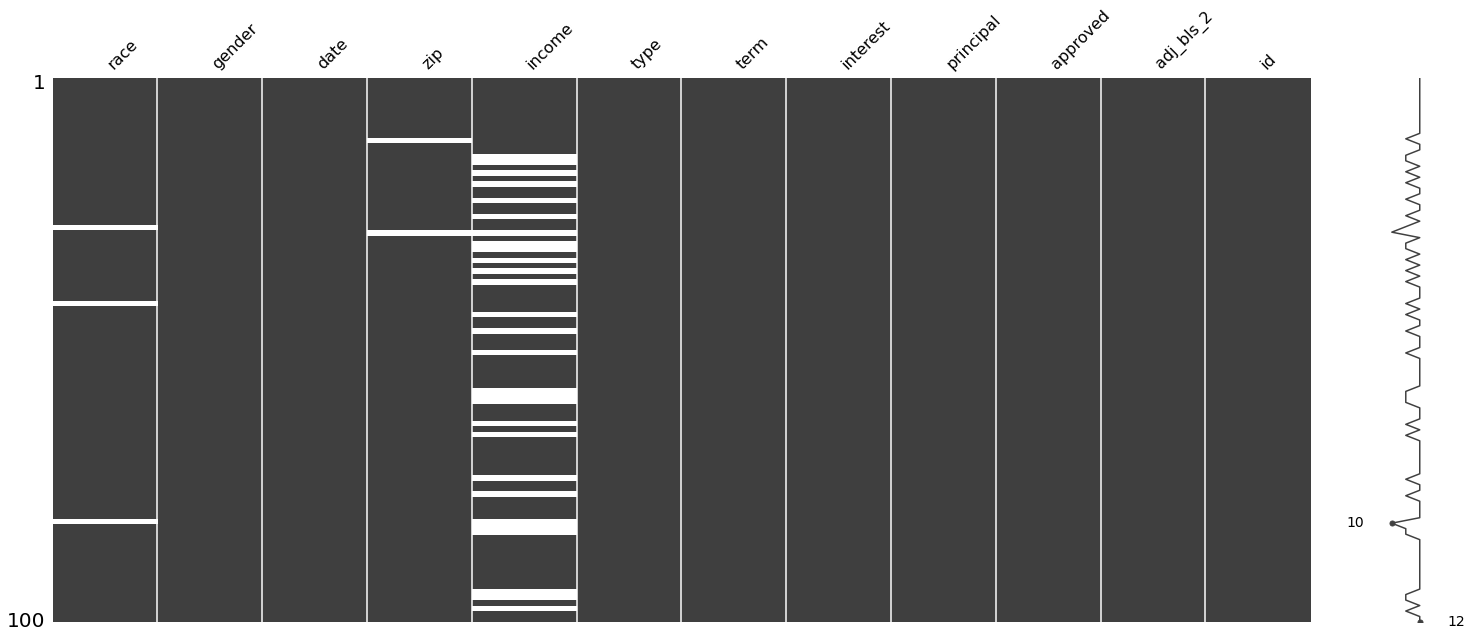

In [20]:
print('\033[1m' + "Visualizing the Missing Data: Data Completion Patterns" + '\033[0m')
print("Note: This is from a random sample of 100 entries.")
msno.matrix(df.sample(100));

Visualizing the Missing Data: Correlation Between Data


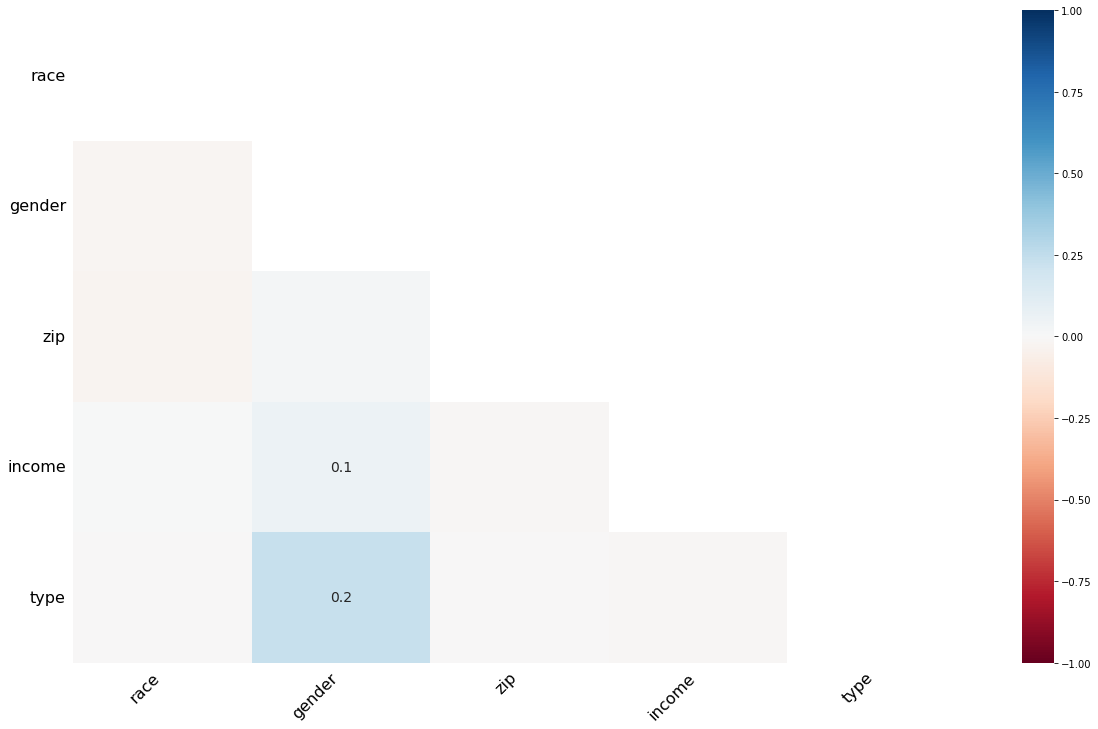

In [21]:
print('\033[1m' + "Visualizing the Missing Data: Correlation Between Data" + '\033[0m')
msno.heatmap(df);

In [22]:
for column in df:
    print("There are " + '\033[1m' + str(df[pd.isnull(df[column])].shape[0]) + '\033[0m' + " missing entries in the '" + column + "' column.")
    if df[pd.isnull(df[column])].shape[0] > 0:
        print("Pick one of the following options to handle these missing entries.")
        print("(1) Leave the missing entries as they are, so the missing values do not contribute to any computations.")
        print("(2) Drop the rows with a missing entry.")
        print("(3) Drop the entire column.")
        print("(4) Simple Imputation: Replace the missing data with a substituted value.")
        if (df[column].dtype == 'int64' or df[column].dtype == 'float64'):
            print("(5) Advanced Imputation: Using Machine Learning to substitute missing data.")
        time.sleep(0.05)
        del_option = input('\033[1m' + "Input the option number: " + '\033[0m')
        if del_option == "1" or del_option == "(1)":
            continue
        elif del_option == "2" or del_option == "(2)":
            df.dropna(subset=[column],how='any',inplace=True)
        elif del_option == "3" or del_option == "(3)":
            df.drop(columns=[column], inplace=True)
        elif del_option == "4" or del_option == "(4)":
            print("(a) Impute with a constant value.")
            print("(b) Impute with the most frequent value.")
            if (df[column].dtype == 'int64' or df[column].dtype == 'float64'):
                print("(c) Impute with the mean value of the column.")
                print("(d) Impute with the median value of the column.")
            time.sleep(0.05)
            imp_option = input('\033[1m' + "Input the letter for simple imputation: " + '\033[0m') 
            if imp_option == 'a' or imp_option == '(a)':
                constant = input('\033[1m' + "Input the constant that you wish to substitute: " + '\033[0m') 
                if (df[column].dtype == 'int64' or df[column].dtype == 'float64'):
                    mean_imputer = SimpleImputer(strategy='constant', fill_value=int(constant))
                elif(df[column].dtype == 'object'):
                    mean_imputer = SimpleImputer(strategy='constant', fill_value=constant)
            elif imp_option == 'b' or imp_option == '(b)':
                mean_imputer = SimpleImputer(strategy='most_frequent')
            elif imp_option == 'c' or imp_option == '(c)':
                mean_imputer = SimpleImputer(strategy='mean')
            elif imp_option == 'd' or imp_option == '(d)':
                mean_imputer = SimpleImputer(strategy='median')
            df[column] = mean_imputer.fit_transform(df[[column]]).ravel()
        elif del_option == "5" or del_option == "(5)":
            print("(a) Impute using the K-Nearest Neighbor Imputation. More details can be found here: https://scikit-learn.org/stable/modules/impute.html#nearest-neighbors-imputation")
            print("(b) Impute using Multivariate imputation by chained equations (MICE). More details can be found here: https://scikit-learn.org/stable/modules/impute.html#multivariate-feature-imputation")
            time.sleep(0.05)
            imp_option = input('\033[1m' + "Input the letter for advanced imputation: " + '\033[0m')
            if imp_option == 'a' or imp_option == '(a)':
                knn_imputer = KNNImputer(n_neighbors=2, weights="uniform")
                df[column] = knn_imputer.fit_transform(df[[column]])
            elif imp_option == 'b' or imp_option == '(b)':
                mice_imputer = IterativeImputer()
                df[column] = mice_imputer.fit_transform(df[[column]])
    print("\n")
print('\033[1m' + "** Missing Data Cleaning Complete! **" + '\033[0m')      

There are 29 missing entries in the 'race' column.
Pick one of the following options to handle these missing entries.
(1) Leave the missing entries as they are, so the missing values do not contribute to any computations.
(2) Drop the rows with a missing entry.
(3) Drop the entire column.
(4) Simple Imputation: Replace the missing data with a substituted value.
Input the option number: 4
(a) Impute with a constant value.
(b) Impute with the most frequent value.
Input the letter for simple imputation: a
Input the constant that you wish to substitute: None


There are 19 missing entries in the 'gender' column.
Pick one of the following options to handle these missing entries.
(1) Leave the missing entries as they are, so the missing values do not contribute to any computations.
(2) Drop the rows with a missing entry.
(3) Drop the entire column.
(4) Simple Imputation: Replace the missing data with a substituted value.
Input the option number: 4
(a) Impute with a constant value.
(b) Impute

## Step 6: Exploring and Exporting the 'Cleaned' Dataset
Now that the dataset has gone through the various stages of data cleaning, you can revisit the dataset and see how certain aspects have changed. You also have to option to export the cleaned dataset as a csv or xlsx file.

In [ ]:
@interact
def describe(column=list(df.columns)):
    print(df[column].describe())

In [ ]:
@interact
def hist_plot(x=list(df.select_dtypes('number').columns),
                 theme=list(cf.themes.THEMES.keys()), 
                 colorscale=list(cf.colors._scales_names.keys())):
        
    df[x].iplot(kind='hist',
             title=f'Histogram of {x}',
            theme=theme, colorscale=colorscale)

In [ ]:
@interact
def scatter_plot(x=list(df.select_dtypes('number').columns), 
                 y=list(df.select_dtypes('number').columns)[1:],
                 theme=list(cf.themes.THEMES.keys()), 
                 colorscale=list(cf.colors._scales_names.keys())):
    print(x)
    df.iplot(kind='scatter', x=x, y=y, mode='markers', 
             xTitle=x, yTitle=y, 
             #text='title',
             title=f'Scatter Plot of {y} against {x}',
            theme=theme, colorscale=colorscale)

In [25]:
print('\033[1m' + "Export the Final Dataset" + '\033[0m')
time.sleep(0.05)
filename = input("Input the filename of the export followed by the file extension: ")
filename_spl = filename.split('.')
if filename_spl[1] == 'csv':
    df.to_csv(filename,index=False)
elif filename_spl[1] == 'csv':
    df.to_excel(filename,index=False)

Export the Final Dataset
Input the filename of the export followed by the file extension: loandata_clean.csv


### Sources Used:
https://stackoverflow.com/questions/8924173/how-to-print-bold-text-in-python  
https://stackoverflow.com/questions/49551336/pandas-trim-leading-trailing-white-space-in-a-dataframe  
https://www.pythontutorial.net/python-string-methods/python-titlecase/  
https://stackoverflow.com/questions/942543/operation-on-every-pair-of-element-in-a-list  
https://pythonhosted.org/ngram/ngram.html  
https://stackoverflow.com/questions/25341945/check-if-string-has-date-any-format  
https://stackoverflow.com/questions/19363881/replace-none-value-in-list  
https://towardsdatascience.com/interactive-controls-for-jupyter-notebooks-f5c94829aee6  
https://stackoverflow.com/questions/64646490/calculate-similarity-between-rows-of-a-dataframe-count-values-in-common  
https://www.kaggle.com/code/parulpandey/a-guide-to-handling-missing-values-in-python/notebook  
https://scikit-learn.org/stable/modules/impute.html  
https://www.kaggle.com/code/vvineeth/plotly-cufflinks-and-iplot/notebook